# Reproduce DL
## Automated Pavement Crack Segmentation

We start by setting up the actual Architecture. This means making sure all weights are properly initialized and all layers are connected. 

We make use of PyTorch for the implementation.

Multiple parts come together (A U-based ResNet);
- We recreate ResNet34 and remove the last two layers
- We made sure that a ResNet-block is either 4 or 6 layers depending on if stride is not 1 (which in our case always happens when the in_channels are not equal to out_channels)
- We use transfer learning such that the ResNet34 parameters are initialized as if trained on ImageNet
- We create Squeeze and Excitation blocks that are applied per Channel (cSE) and per Spatial (sSE) (image)
- These two blocks are combined (scSE) and then the maximum of this is taken
- Each convolutional layer its parameters are initialized via "He Kaiming" method.

In [ ]:
# Do all the imports
## Packages
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm
from torchsummary import summary
import torch.nn as nn
import torch
import pandas as pd
import os

## Project
from architecture import main
from datasets.CFD.CFDdata import CFD
from datasets.CRACK500.CRACKdata import C5D
from loss.loss import batch_dice_loss
from utils.layers import layer_split
from utils.retrieve_device import try_gpu

The current dataset is size:  118 
The current split is train/test:  71 / 47


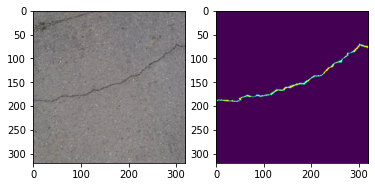

In [ ]:
# Image factor explanation:
# 1 = 320
# 0.8 = 256
# 0.4 = 128
split_seed = 42

def get_data_loaders(img_factor=1, dataset="CFD"):
    # Define standard variables
    current_path = os.path.abspath(os.getcwd())
    image = "/datasets/CFD/cfd_image/"
    gt = "/datasets/CFD/seg_gt/"
    ratio = [71, 47]
    batch_size = 25
    batch_size_t = 47

    if dataset == "CRACK500":
        image = "/datasets/CRACK500/crack_image/"
        gt = "/datasets/CRACK500/seg_gt/"
        ratio = [300, 200]

    tf_compos, tf_compos_gt = get_transforms(img_factor)
    if dataset == "CFD":
        dataset = CFD(current_path + image, tf_compos, current_path + gt, tf_compos_gt)
    else:
        dataset = C5D(current_path + image, tf_compos, current_path + gt, tf_compos_gt)

    # Manual seed added such that same split is kept,
    # even though a new split is made with different sizes
    print(f"dataset len: {len(dataset)}")
    train_data, test_data = random_split(dataset, ratio,
                                         generator=torch.Generator().manual_seed(split_seed))
    train_loader = DataLoader(train_data, batch_size=batch_size)
    test_loader = DataLoader(test_data, batch_size=batch_size_t)
    
    print(f"dataset: {len(dataset)}, objects_train: {len(train_data)}, BS_train: {batch_size}, dataloader len: {len(train_loader)}")
    print(f"objects_test: {len(test_data)}, BS_test: {batch_size_t}, dataloader len: {len(test_loader)}")

    return dataset, train_loader, test_loader


def get_transforms(img_factor):
    resize_image = tuple(int(img_factor * x) for x in (320, 480))
    crop_image = resize_image[0]

    shared_transforms = [
        transforms.RandomCrop(crop_image),
        transforms.Pad(200, padding_mode='reflect'),
        transforms.RandomRotation((0,360)),
        transforms.CenterCrop(crop_image),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
    ]
    # Bilinear interpolation since value can be [-255, +255]
    tf_compos = transforms.Compose([
        transforms.Resize(resize_image, interpolation=InterpolationMode.BILINEAR),
        *shared_transforms, 
        transforms.ColorJitter(brightness=0.05, contrast=0.05), 
        transforms.ToTensor()
        ])
    # NN interpolation since value can only be [0 or 1], 
    # Bilinear, should be tested at some point, however.
    tf_compos_gt = transforms.Compose([
        transforms.Resize(resize_image, interpolation=InterpolationMode.NEAREST),
        *shared_transforms, 
        transforms.ToTensor()
        ])
    return tf_compos, tf_compos_gt

In [ ]:
def batch_get_new_label(old_labels, predictions):
    old_with_padding = nn.ReplicationPad2d(2)(old_labels)
    extended_labels = nn.MaxPool2d(5, stride=1)(old_with_padding)
    extension = extended_labels - old_labels
    
    # Transforms only the extension area to contain 0 if prediction is 0 and 1 if prediction is 1
    ext_isect_pred = torch.logical_and(extension, predictions)
    
    # Combines this new extension area with old label
    new_label = torch.logical_or(old_labels, ext_isect_pred).float()
    return new_label

In [ ]:
def get_prec_recall(data_loader, network, device=torch.device("cpu")):
    network.eval()
    isect_sum = torch.tensor([0], dtype=torch.float32, device=device)
    positive_predicts_pixels = 0
    positive_truth_pixels = 0

    for X, y in data_loader:
        # Copy the data to device.
        X, y = X.to(device), y.to(device)
        with torch.no_grad():
            pred = (network(X) >= 0.5).float()
            y_ext = batch_get_new_label(y, pred)
            isect_sum += torch.sum(torch.logical_and(y_ext, pred))
            positive_predicts_pixels += torch.sum(pred)
            positive_truth_pixels += torch.sum(y_ext)

    precision = ( isect_sum + 1e-8 ) / ( positive_predicts_pixels + 1e-8 )
    recall = ( isect_sum + 1e-8 )/ ( positive_truth_pixels + 1e-8 )
    return (precision.item(), recall.item())


def get_f1(precision, recall):
    return 2*precision*recall / (precision+recall)

In [ ]:
# Elaborate loop of multiple Epoch
# training parameters
lr = 0.05

# Always needs to be a factor of 3
# Phase 1 = 1/3 time, Phase 2 = 2/3 time
EPOCHS = 90
epochs_1 = ( EPOCHS // 3 )
epochs_2 = ( EPOCHS // 3 ) * 2

# Define list to store losses and performances of each interation
metrics = []

# Try using gpu
device = torch.device('cuda:0')

#Initialize network
network = main.Net()

#Initiliaze loss function
criterion = batch_dice_loss

# Split layers into three, for seperate optimization
layer_1, layer_2, layer_3 = layer_split(network)
datasetname = "CFD"

optimizer = torch.optim.AdamW([
    {'params': layer_1, 'name': 'layer_1'},
    {'params': layer_2, 'name': 'layer_2'},
    {'params': layer_3, 'name': 'layer_3'}], betas=(0.9, 0.999), weight_decay = 0.01)



# Get dataloaders (128x128)
dataset, train_loader, test_loader = get_data_loaders(0.4, datasetname)

# Look at this more carefully
# it should do this:
# - max lr is 1.0
# - start at 5% (0.05) of max_lr 
# - linearly build up
# - max_lr at (total_epoch * 0.4)
# - linearly break down
# - end at 0.00005 lr at last epoch
# Three phase: 
# - Up from initial to max,
# - Down from max to initial,
# - Down from initial to minimum
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=1.0,
    epochs=EPOCHS,
    steps_per_epoch=len(train_loader),
    anneal_strategy='linear',
    pct_start=0.4, 
    div_factor=20,
    final_div_factor=20000,
    three_phase=True
    )


for epoch in tqdm(range(EPOCHS)):
    # Network in training mode and to device
    network.train()
    network.to(device)
    
    optimizer.param_groups[0]["lr"] = 0 if epoch < epochs_1 else optimizer.param_groups[2]["lr"] / 9
    optimizer.param_groups[1]["lr"] = optimizer.param_groups[2]["lr"] / 3

    print(f"epoch: {epoch+1}, lr_layer_3 = {optimizer.param_groups[2]['lr']}")
    
    
    
    if (epoch == epochs_1):
        # Get dataloaders (256x256)
        get_data_loaders(0.8, datasetname)

    if (epoch == epochs_2):
        # Get dataloaders (320x320)
        get_data_loaders(1, datasetname)

    # Training loop
    for i, (x_batch, y_batch) in enumerate(train_loader):

        # Set to same device
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # Set the gradients to zero
        optimizer.zero_grad()

        # Perform forward pass
        y_pred = network(x_batch)

        # Compute the loss
        loss = criterion(y_pred, y_batch)

        # Backward computation and update
        loss.backward()
        optimizer.step()
        scheduler.step()
    
    # Compute precision, recall, and f1 for train and test data
    if epoch >= EPOCHS - 3:
        train_prec, train_recall = get_prec_recall(train_loader, network.to("cpu"))
        train_f1 = get_f1(train_prec, train_recall)
        test_prec, test_recall = get_prec_recall(test_loader, network.to("cpu"))
        test_f1 = get_f1(test_prec, test_recall)
        metrics.append([train_prec, train_recall, train_f1, test_prec, test_recall, test_f1, loss.tolist()])

        # Print performance
        print('Epoch: {:.0f}'.format(epoch+1))
        print(f'Precision, Recall, and F1 of train set: {train_prec}, {train_recall}, {train_f1}')
        print(f'Precision, Recall, and F1 of test set: {test_prec}, {test_recall}, {test_f1}')
        print('')


# Save model
model_state = network.state_dict()
reproduction_info = { "params": model_state, "split_seed": split_seed }
torch.save(model_state, "model_parameters.pt")

# Write metrics to disk
df = pd.DataFrame(metrics, columns=[
    "train_prec", "train_recall", "train_f1", "test_prec", "test_recall", "test_f1", "loss"])
df.to_csv("metrics.csv", index=False)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

  0%|          | 0/30 [00:00<?, ?it/s]

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
# Set up simple loop on GPU, one epoch
# training parameters
lr = 1e-3

epochs = 10

# Define list to store losses and performances of each interation
images = []
labels = []
predictions = []

# Try using gpu
device = torch.device('cuda:0')

#Initialize network
network = main.Net()

#Initiliaze loss function
criterion = batch_dice_loss

optimizer = torch.optim.AdamW(network.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay = 0.01)

# Get dataloaders
_, train_loader, test_loader = get_data_loaders()


for epoch in tqdm(range(epochs)):

    # Network in training mode and to device
    network.train()
    network.to(device)

    # Training loop
    for i, (x_batch, y_batch) in enumerate(train_loader):

        # Set to same device
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # Set the gradients to zero
        optimizer.zero_grad()

        # Perform forward pass
        y_pred = network(x_batch)

        # Compute the loss
        loss = criterion(y_pred, y_batch)

        # Backward computation and update
        loss.backward()
        optimizer.step()
    
    # Compute precision, recall, and f1 for train and test data
    train_prec, train_recall = get_prec_recall(train_loader, network.to("cpu"))
    train_f1 = get_f1(train_prec, train_recall)
    test_prec, test_recall = get_prec_recall(test_loader, network.to("cpu"))
    test_f1 = get_f1(test_prec, test_recall)

    # Print performance
    print('Epoch: {:.0f}'.format(epoch+1))
    print(f'Precision, Recall, and F1 of train set: {train_prec}, {train_recall}, {train_f1}')
    print(f'Precision, Recall, and F1 of test set: {test_prec}, {test_recall}, {test_f1}')
    print('')

# Save model
model_state = network.state_dict()
torch.save(model_state, "model_parameters_gpu_test.pt")

In [ ]:
# Summarize the Architecture as output
network = main.Net()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = network.to(device)

# print(network)
summary(model, input_size=(3, 320, 480))

In [ ]:
# from torchviz import make_dot

# x = torch.randn(1,3, 320, 480)
# y = net(x) 

# make_dot(y).view()

In [ ]:
def epoch_to_PIL(data_loader, network, device=torch.device("cpu")) -> dict:
    converted = {"xs": [], "ys": [], "preds": []}
    for x_batch, y_batch in data_loader:
        preds = network(x_batch)
        converted["xs"].extend(batch_to_PIL(x_batch))
        converted["ys"].extend(batch_to_PIL(y_batch))
        converted["preds"].extend(batch_to_PIL(preds))
    return converted


def batch_to_PIL(tensor_batch) -> list:
    converted = []
    for t in tensor_batch:
        img = transforms.ToPILImage()(t)
        converted.append(img)
    return converted

network = main.Net()
model.load_state_dict(torch.load("model_parametersC5D.pt")["params"])
model.eval()

pics = epoch_to_PIL(test_loader, network)

#subplot(r,c) provide the no. of rows and columns
n_examples = 10
f, axarr = plt.subplots(n_examples,3, figsize=(15, n_examples*4)) 

for i in range(n_examples):
    axarr[i][0].imshow(pics["xs"][i])
    axarr[i][1].imshow(pics["ys"][i])
    axarr[i][2].imshow(pics["preds"][i])


KeyboardInterrupt: 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=411d58e9-cb4b-4924-bef0-2f383eff0187' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>